In [1]:
%%capture
import os, re
if "COLAB_" not in "".join(os.environ.keys()):
    !pip install unsloth
else:
    # Do this only in Colab notebooks! Otherwise use pip install unsloth
    import torch; v = re.match(r"[0-9]{1,}\.[0-9]{1,}", str(torch.__version__)).group(0)
    xformers = "xformers==" + ("0.0.33.post1" if v=="2.9" else "0.0.32.post2" if v=="2.8" else "0.0.29.post3")
    !pip install --no-deps bitsandbytes accelerate {xformers} peft trl triton cut_cross_entropy unsloth_zoo
    !pip install sentencepiece protobuf "datasets==4.3.0" "huggingface_hub>=0.34.0" hf_transfer
    !pip install --no-deps unsloth
!pip install transformers==4.56.2
!pip install --no-deps trl==0.22.2
!pip install jiwer
!pip install einops addict easydict

# 1. Load Deepseek model 

In [2]:
from huggingface_hub import snapshot_download
snapshot_download("unsloth/DeepSeek-OCR", local_dir = "/kaggle/working/deepseek_ocr")

Fetching 21 files:   0%|          | 0/21 [00:00<?, ?it/s]

README-checkpoint.md: 0.00B [00:00, ?B/s]

README.md: 0.00B [00:00, ?B/s]

assets/show2.jpg:   0%|          | 0.00/216k [00:00<?, ?B/s]

assets/show3.jpg:   0%|          | 0.00/247k [00:00<?, ?B/s]

.gitattributes: 0.00B [00:00, ?B/s]

assets/fig1.png:   0%|          | 0.00/396k [00:00<?, ?B/s]

LICENSE: 0.00B [00:00, ?B/s]

assets/show4.jpg:   0%|          | 0.00/269k [00:00<?, ?B/s]

assets/show1.jpg:   0%|          | 0.00/117k [00:00<?, ?B/s]

config.json: 0.00B [00:00, ?B/s]

configuration_deepseek_v2.py: 0.00B [00:00, ?B/s]

conversation.py: 0.00B [00:00, ?B/s]

deepencoder.py: 0.00B [00:00, ?B/s]

model-00001-of-000001.safetensors:   0%|          | 0.00/6.67G [00:00<?, ?B/s]

model.safetensors.index.json: 0.00B [00:00, ?B/s]

modeling_deepseekocr.py: 0.00B [00:00, ?B/s]

processor_config.json:   0%|          | 0.00/460 [00:00<?, ?B/s]

modeling_deepseekv2.py: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/801 [00:00<?, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

tokenizer_config.json: 0.00B [00:00, ?B/s]

'/kaggle/working/deepseek_ocr'

In [3]:
import unsloth
import os
import torch
import sys
from tqdm import tqdm
import jiwer
import pandas as pd
from PIL import Image
import matplotlib.pyplot as plt

🦥 Unsloth: Will patch your computer to enable 2x faster free finetuning.


2025-12-10 02:54:55.734480: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1765335295.936062      20 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1765335295.986913      20 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


🦥 Unsloth Zoo will now patch everything to make training faster!


In [4]:
from unsloth import FastVisionModel # FastLanguageModel for LLMs
import torch
from transformers import AutoModel
import os
os.environ["UNSLOTH_WARN_UNINITIALIZED"] = '0'
# 4bit pre quantized models we support for 4x faster downloading + no OOMs.
fourbit_models = [
    "unsloth/Qwen3-VL-8B-Instruct-bnb-4bit", # Qwen 3 vision support
    "unsloth/Qwen3-VL-8B-Thinking-bnb-4bit",
    "unsloth/Qwen3-VL-32B-Instruct-bnb-4bit",
    "unsloth/Qwen3-VL-32B-Thinking-bnb-4bit",
] # More models at https://huggingface.co/unsloth

model, tokenizer = FastVisionModel.from_pretrained(
    "/kaggle/working/deepseek_ocr",
    load_in_4bit = True, # Use 4bit to reduce memory use. False for 16bit LoRA.
    auto_model = AutoModel,
    trust_remote_code=True,
    unsloth_force_compile=True,
    use_gradient_checkpointing = "unsloth", # True or "unsloth" for long context
)

You are using a model of type deepseek_vl_v2 to instantiate a model of type DeepseekOCR. This is not supported for all configurations of models and can yield errors.


Unsloth: WARNING `trust_remote_code` is True.
Are you certain you want to do remote code execution?
==((====))==  Unsloth 2025.12.1: Fast Deepseekocr patching. Transformers: 4.56.2.
   \\   /|    Tesla P100-PCIE-16GB. Num GPUs = 1. Max memory: 15.888 GB. Platform: Linux.
O^O/ \_/ \    Torch: 2.6.0+cu124. CUDA: 6.0. CUDA Toolkit: 12.4. Triton: 3.2.0
\        /    Bfloat16 = FALSE. FA [Xformers = 0.0.29.post3. FA2 = False]
 "-____-"     Free license: http://github.com/unslothai/unsloth
Unsloth: Fast downloading is enabled - ignore downloading bars which are red colored!


You are using a model of type deepseek_vl_v2 to instantiate a model of type DeepseekOCR. This is not supported for all configurations of models and can yield errors.
You are using a model of type deepseek_vl_v2 to instantiate a model of type DeepseekOCR. This is not supported for all configurations of models and can yield errors.
Some weights of DeepseekOCRForCausalLM were not initialized from the model checkpoint at /kaggle/working/deepseek_ocr and are newly initialized: ['model.vision_model.embeddings.position_ids']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [5]:
# prompt = "<image>\nFree OCR. "
prompt = "<image>\nFree OCR. "
image_file = '/kaggle/input/uit-hwdb-dataset/UIT_HWDB_line/UIT_HWDB_line/test_data/250/1.jpg'
output_path = '/kaggle/working/'
# infer(self, tokenizer, prompt='', image_file='', output_path = ' ', base_size = 1024, image_size = 640, crop_mode = True, test_compress = False, save_results = False):

# Tiny: base_size = 512, image_size = 512, crop_mode = False
# Small: base_size = 640, image_size = 640, crop_mode = False
# Base: base_size = 1024, image_size = 1024, crop_mode = False
# Large: base_size = 1280, image_size = 1280, crop_mode = False

# Gundam: base_size = 1024, image_size = 640, crop_mode = True

res = model.infer(tokenizer, prompt=prompt, image_file=image_file, output_path = output_path, base_size = 1024, image_size = 640, crop_mode=True, save_results = True, test_compress = False)


The attention mask is not set and cannot be inferred from input because pad token is same as eos token. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.


BASE:  torch.Size([1, 256, 1280])
PATCHES:  torch.Size([9, 100, 1280])
Thứ tháng Bảy năm ngày và mới tháng Đáng Hùng vào năm 1942 với:
===============save results:===============


image: 0it [00:00, ?it/s]
other: 0it [00:00, ?it/s]


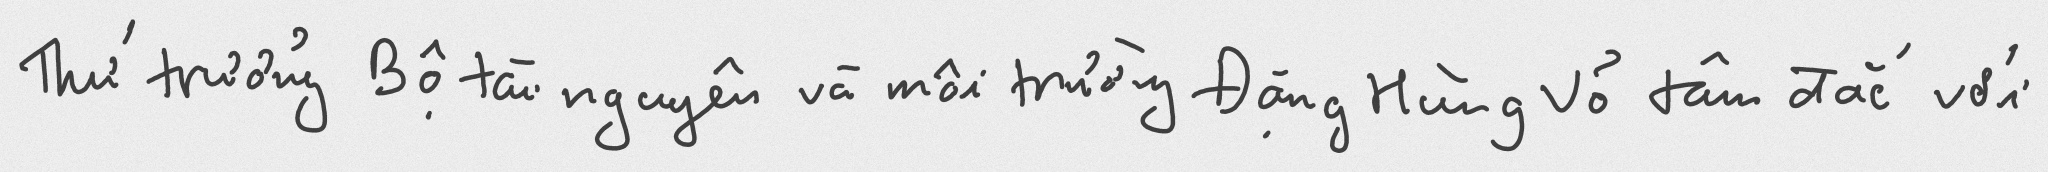

In [6]:
image_test = Image.open(image_file)
image_test

# 2. Prepare data for fine-tuning

In [7]:
from torch.utils.data import Dataset
import json


class HWDBDataset(Dataset):
    def __init__(self, root, isTrain = True ,transform=None):
        """
        split_path:
            .../UIT_HWDB_line/UIT_HWDB_line/train_data
            .../UIT_HWDB_line/UIT_HWDB_line/test_data
        """
        self.samples = []
        self.transform = transform
        train_test = "train_data" if isTrain else "test_data"
        
        data = ["UIT_HWDB_line", "UIT_HWDB_paragraph", "UIT_HWDB_word"]
        # scan folders
        cnt = 0
        for d in data:
            p = os.path.join(root, d, d)
            split_path = os.path.join(p, train_test)
            print(split_path)
            
            for cls in os.listdir(split_path):
                folder = os.path.join(split_path, cls)
                if not os.path.isdir(folder):
                    continue
    
                label_path = os.path.join(folder, "label.json")
                if not os.path.exists(label_path):
                    continue
    
                # load labels
                with open(label_path, "r", encoding="utf-8") as f:
                    labels = json.load(f)
    
                # collect all samples
                for fname, text in labels.items():
                    img_path = os.path.join(folder, fname)
    
                    if os.path.exists(img_path):
                        self.samples.append({
                            "image_path": img_path,
                            "text": text.strip()
                        })
                        cnt += 1
                if cnt >= 80000:
                    break
            if cnt >= 80000:
                break
        print("done!")

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        sample = self.samples[idx]

        # # load image on demand
        # img = Image.open(sample["image_path"]).convert("RGB")

        # if self.transform is not None:
        #     img = self.transform(img)

        return {
            "image": sample["image_path"],
            "text": sample["text"]
        }


In [8]:
root = "/kaggle/input/uit-hwdb-dataset"

train_dataset = HWDBDataset(root, True)
test_dataset  = HWDBDataset(root, False)

print(len(train_dataset), len(test_dataset))

/kaggle/input/uit-hwdb-dataset/UIT_HWDB_line/UIT_HWDB_line/train_data
/kaggle/input/uit-hwdb-dataset/UIT_HWDB_paragraph/UIT_HWDB_paragraph/train_data
/kaggle/input/uit-hwdb-dataset/UIT_HWDB_word/UIT_HWDB_word/train_data
done!
/kaggle/input/uit-hwdb-dataset/UIT_HWDB_line/UIT_HWDB_line/test_data
/kaggle/input/uit-hwdb-dataset/UIT_HWDB_paragraph/UIT_HWDB_paragraph/test_data
/kaggle/input/uit-hwdb-dataset/UIT_HWDB_word/UIT_HWDB_word/test_data
done!
80279 3113


In [9]:
instruction = "<image>\nFree OCR. "   # nội dung bạn muốn trong 'content'

def convert_to_conversation(sample):
    """
    sample expected to be: {"image": PIL.Image, "text": str}
    """
    image_path = sample.get("image")

    # defensive: nếu dataset trả image_path thay vì image, mở bằng PIL
    # if image_obj is None and "image_path" in sample:
    image_obj = Image.open(image_path).convert("RGB")

    # final check
    assert hasattr(image_obj, "size") and hasattr(image_obj, "mode"), \
        "image is not a PIL image"

    conversation = [
        {
            "role": "<|User|>",
            "content": instruction,
            "images": [image_obj],
        },
        {
            "role": "<|Assistant|>",
            "content": sample["text"]
        }
    ]
    return {"messages": conversation}

In [10]:
converted_dataset = [convert_to_conversation(sample) for sample in train_dataset]

In [11]:
train_dataset[0]

{'image': '/kaggle/input/uit-hwdb-dataset/UIT_HWDB_line/UIT_HWDB_line/train_data/248/1.jpg',
 'text': 'Chuyện những người mang số 115. Sáng nay ngồi quán cà phê cóc, ông bạn già của tôi tâm sự :'}

In [12]:
converted_dataset[0]

{'messages': [{'role': '<|User|>',
   'content': '<image>\nFree OCR. ',
   'images': [<PIL.Image.Image image mode=RGB size=2048x112>]},
  {'role': '<|Assistant|>',
   'content': 'Chuyện những người mang số 115. Sáng nay ngồi quán cà phê cóc, ông bạn già của tôi tâm sự :'}]}

In [13]:
model = FastVisionModel.get_peft_model(
    model,
    target_modules=[
        "q_proj",
        "k_proj",
        "v_proj",
        "o_proj",
        "gate_proj",
        "up_proj",
        "down_proj",
    ],

    r = 16,           # The larger, the higher the accuracy, but might overfit
    lora_alpha = 16,  # Recommended alpha == r at least
    lora_dropout = 0,
    bias = "none",
    random_state = 3407,
    use_rslora = False,  # We support rank stabilized LoRA
    loftq_config = None, # And LoftQ
    # target_modules = "all-linear", # Optional now! Can specify a list if needed
)

Unsloth: Making `model.base_model.model.model` require gradients


# 3. Create datacollator

In [14]:
# # @title Create datacollator

import math
from dataclasses import dataclass
from typing import Dict, List, Any, Tuple
from PIL import Image, ImageOps
from torch.nn.utils.rnn import pad_sequence
import io

from deepseek_ocr.modeling_deepseekocr import (
    format_messages,
    text_encode,
    BasicImageTransform,
    dynamic_preprocess,
)

@dataclass
class DeepSeekOCRDataCollator:
    """
    Args:
        tokenizer: Tokenizer
        model: Model
        image_size: Size for image patches (default: 640)
        base_size: Size for global view (default: 1024)
        crop_mode: Whether to use dynamic cropping for large images
        train_on_responses_only: If True, only train on assistant responses (mask user prompts)
    """
    tokenizer: Any
    model: Any
    image_size: int = 640
    base_size: int = 1024
    crop_mode: bool = True
    image_token_id: int = 128815
    train_on_responses_only: bool = True

    def __init__(
        self,
        tokenizer,
        model,
        image_size: int = 640,
        base_size: int = 1024,
        crop_mode: bool = True,
        train_on_responses_only: bool = True,
    ):
        self.tokenizer = tokenizer
        self.model = model
        self.image_size = image_size
        self.base_size = base_size
        self.crop_mode = crop_mode
        self.image_token_id = 128815
        self.dtype = model.dtype  # Get dtype from model
        self.train_on_responses_only = train_on_responses_only

        self.image_transform = BasicImageTransform(
            mean=(0.5, 0.5, 0.5),
            std=(0.5, 0.5, 0.5),
            normalize=True
        )
        self.patch_size = 16
        self.downsample_ratio = 4

        # Get BOS token ID from tokenizer
        if hasattr(tokenizer, 'bos_token_id') and tokenizer.bos_token_id is not None:
            self.bos_id = tokenizer.bos_token_id
        else:
            self.bos_id = 0
            print(f"Warning: tokenizer has no bos_token_id, using default: {self.bos_id}")

    def deserialize_image(self, image_data) -> Image.Image:
        """Convert image data (bytes dict or PIL Image) to PIL Image in RGB mode"""
        if isinstance(image_data, Image.Image):
            return image_data.convert("RGB")
        elif isinstance(image_data, dict) and 'bytes' in image_data:
            image_bytes = image_data['bytes']
            image = Image.open(io.BytesIO(image_bytes))
            return image.convert("RGB")
        else:
            raise ValueError(f"Unsupported image format: {type(image_data)}")

    def calculate_image_token_count(self, image: Image.Image, crop_ratio: Tuple[int, int]) -> int:
        """Calculate the number of tokens this image will generate"""
        num_queries = math.ceil((self.image_size // self.patch_size) / self.downsample_ratio)
        num_queries_base = math.ceil((self.base_size // self.patch_size) / self.downsample_ratio)

        width_crop_num, height_crop_num = crop_ratio

        if self.crop_mode:
            img_tokens = num_queries_base * num_queries_base + 1
            if width_crop_num > 1 or height_crop_num > 1:
                img_tokens += (num_queries * width_crop_num + 1) * (num_queries * height_crop_num)
        else:
            img_tokens = num_queries * num_queries + 1

        return img_tokens

    def process_image(self, image: Image.Image) -> Tuple[List, List, List, List, Tuple[int, int]]:
        """
        Process a single image based on crop_mode and size thresholds

        Returns:
            Tuple of (images_list, images_crop_list, images_spatial_crop, tokenized_image, crop_ratio)
        """
        images_list = []
        images_crop_list = []
        images_spatial_crop = []

        if self.crop_mode:
            # Determine crop ratio based on image size
            if image.size[0] <= 640 and image.size[1] <= 640:
                crop_ratio = (1, 1)
                images_crop_raw = []
            else:
                images_crop_raw, crop_ratio = dynamic_preprocess(
                    image, min_num=2, max_num=9,
                    image_size=self.image_size, use_thumbnail=False
                )

            # Process global view with padding
            global_view = ImageOps.pad(
                image, (self.base_size, self.base_size),
                color=tuple(int(x * 255) for x in self.image_transform.mean)
            )
            images_list.append(self.image_transform(global_view).to(self.dtype))

            width_crop_num, height_crop_num = crop_ratio
            images_spatial_crop.append([width_crop_num, height_crop_num])

            # Process local views (crops) if applicable
            if width_crop_num > 1 or height_crop_num > 1:
                for crop_img in images_crop_raw:
                    images_crop_list.append(
                        self.image_transform(crop_img).to(self.dtype)
                    )

            # Calculate image tokens
            num_queries = math.ceil((self.image_size // self.patch_size) / self.downsample_ratio)
            num_queries_base = math.ceil((self.base_size // self.patch_size) / self.downsample_ratio)

            tokenized_image = ([self.image_token_id] * num_queries_base + [self.image_token_id]) * num_queries_base
            tokenized_image += [self.image_token_id]

            if width_crop_num > 1 or height_crop_num > 1:
                tokenized_image += ([self.image_token_id] * (num_queries * width_crop_num) + [self.image_token_id]) * (
                    num_queries * height_crop_num)

        else:  # crop_mode = False
            crop_ratio = (1, 1)
            images_spatial_crop.append([1, 1])

            # For smaller base sizes, resize; for larger, pad
            if self.base_size <= 640:
                resized_image = image.resize((self.base_size, self.base_size), Image.LANCZOS)
                images_list.append(self.image_transform(resized_image).to(self.dtype))
            else:
                global_view = ImageOps.pad(
                    image, (self.base_size, self.base_size),
                    color=tuple(int(x * 255) for x in self.image_transform.mean)
                )
                images_list.append(self.image_transform(global_view).to(self.dtype))

            num_queries = math.ceil((self.base_size // self.patch_size) / self.downsample_ratio)
            tokenized_image = ([self.image_token_id] * num_queries + [self.image_token_id]) * num_queries
            tokenized_image += [self.image_token_id]

        return images_list, images_crop_list, images_spatial_crop, tokenized_image, crop_ratio

    def process_single_sample(self, messages: List[Dict]) -> Dict[str, Any]:
            """
            Process a single conversation into model inputs.
            """

            # --- 1. Setup ---
            images = []
            for message in messages:
                if "images" in message and message["images"]:
                    for img_data in message["images"]:
                        if img_data is not None:
                            pil_image = self.deserialize_image(img_data)
                            images.append(pil_image)

            if not images:
                raise ValueError("No images found in sample. Please ensure all samples contain images.")

            tokenized_str = []
            images_seq_mask = []
            images_list, images_crop_list, images_spatial_crop = [], [], []

            prompt_token_count = -1 # Index to start training
            assistant_started = False
            image_idx = 0

            # Add BOS token at the very beginning
            tokenized_str.append(self.bos_id)
            images_seq_mask.append(False)

            for message in messages:
                role = message["role"]
                content = message["content"]

                # Check if this is the assistant's turn
                if role == "<|Assistant|>":
                    if not assistant_started:
                        # This is the split point. All tokens added *so far*
                        # are part of the prompt.
                        prompt_token_count = len(tokenized_str)
                        assistant_started = True

                    # Append the EOS token string to the *end* of assistant content
                    content = f"{content.strip()} {self.tokenizer.eos_token}"

                # Split this message's content by the image token
                text_splits = content.split('<image>')

                for i, text_sep in enumerate(text_splits):
                    # Tokenize the text part
                    tokenized_sep = text_encode(self.tokenizer, text_sep, bos=False, eos=False)
                    tokenized_str.extend(tokenized_sep)
                    images_seq_mask.extend([False] * len(tokenized_sep))

                    # If this text is followed by an <image> tag
                    if i < len(text_splits) - 1:
                        if image_idx >= len(images):
                            raise ValueError(
                                f"Data mismatch: Found '<image>' token but no corresponding image."
                            )

                        # Process the image
                        image = images[image_idx]
                        img_list, crop_list, spatial_crop, tok_img, _ = self.process_image(image)

                        images_list.extend(img_list)
                        images_crop_list.extend(crop_list)
                        images_spatial_crop.extend(spatial_crop)

                        # Add image placeholder tokens
                        tokenized_str.extend(tok_img)
                        images_seq_mask.extend([True] * len(tok_img))

                        image_idx += 1 # Move to the next image

            # --- 3. Validation and Final Prep ---
            if image_idx != len(images):
                raise ValueError(
                    f"Data mismatch: Found {len(images)} images but only {image_idx} '<image>' tokens were used."
                )

            # If we never found an assistant message, we're in a weird state
            # (e.g., user-only prompt). We mask everything.
            if not assistant_started:
                print("Warning: No assistant message found in sample. Masking all tokens.")
                prompt_token_count = len(tokenized_str)

            # Prepare image tensors
            images_ori = torch.stack(images_list, dim=0)
            images_spatial_crop_tensor = torch.tensor(images_spatial_crop, dtype=torch.long)

            if images_crop_list:
                images_crop = torch.stack(images_crop_list, dim=0)
            else:
                images_crop = torch.zeros((1, 3, self.base_size, self.base_size), dtype=self.dtype)

            return {
                "input_ids": torch.tensor(tokenized_str, dtype=torch.long),
                "images_seq_mask": torch.tensor(images_seq_mask, dtype=torch.bool),
                "images_ori": images_ori,
                "images_crop": images_crop,
                "images_spatial_crop": images_spatial_crop_tensor,
                "prompt_token_count": prompt_token_count, # This is now accurate
            }

    def __call__(self, features: List[Dict[str, Any]]) -> Dict[str, torch.Tensor]:
        """Collate batch of samples"""
        batch_data = []

        # Process each sample
        for feature in features:
            try:
                processed = self.process_single_sample(feature['messages'])
                batch_data.append(processed)
            except Exception as e:
                print(f"Error processing sample: {e}")
                continue

        if not batch_data:
            raise ValueError("No valid samples in batch")

        # Extract lists
        input_ids_list = [item['input_ids'] for item in batch_data]
        images_seq_mask_list = [item['images_seq_mask'] for item in batch_data]
        prompt_token_counts = [item['prompt_token_count'] for item in batch_data]

        # Pad sequences
        input_ids = pad_sequence(input_ids_list, batch_first=True, padding_value=self.tokenizer.pad_token_id)
        images_seq_mask = pad_sequence(images_seq_mask_list, batch_first=True, padding_value=False)

        # Create labels
        labels = input_ids.clone()

        # Mask padding tokens
        labels[labels == self.tokenizer.pad_token_id] = -100

        # Mask image tokens (model shouldn't predict these)
        labels[images_seq_mask] = -100

        # Mask user prompt tokens when train_on_responses_only=True (only train on assistant responses)
        if self.train_on_responses_only:
            for idx, prompt_count in enumerate(prompt_token_counts):
                if prompt_count > 0:
                    labels[idx, :prompt_count] = -100

        # Create attention mask
        attention_mask = (input_ids != self.tokenizer.pad_token_id).long()

        # Prepare images batch (list of tuples)
        images_batch = []
        for item in batch_data:
            images_batch.append((item['images_crop'], item['images_ori']))

        # Stack spatial crop info
        images_spatial_crop = torch.cat([item['images_spatial_crop'] for item in batch_data], dim=0)

        return {
            "input_ids": input_ids,
            "attention_mask": attention_mask,
            "labels": labels,
            "images": images_batch,
            "images_seq_mask": images_seq_mask,
            "images_spatial_crop": images_spatial_crop,
        }

# 4. Test and evaluate base model

Because of the computational cost, I can only test on the first 20 data samples.

In [15]:
stdout_backup = sys.stdout
sys.stdout = open("base_output_log.txt", "w")
PROMPT = "<image>\nFree OCR. "
tmp = 0
for c in tqdm(test_dataset, desc="Evaluating"):
    # Make sure path is absolute
    img_path, gt_text = c["image"], c["text"]

    # image = Image.open(img_path).convert("RGB")
    try:
        # # This is the EXACT same inference call you saw
        result = model.infer(
            tokenizer=tokenizer,
            prompt=PROMPT,
            image_file=img_path,
            output_path="./eval_outputs",
            image_size=640,        
            base_size=1024,
            crop_mode=True,        # ← very important for paragraph/handwriting!
            save_results=False,    # we don't need saved images
            test_compress=False
        )
        tmp += 1
        
        print(f"y_true: {gt_text}")
    except Exception as e:
        print(f"Error on {img_path}: {e}")
        pred_text = ""
    if tmp > 20 :
        break
    # all_preds.append(pred_text)
    # all_gts.append(gt_text)
sys.stdout.close()
sys.stdout = stdout_backup

Evaluating:   1%|          | 20/3113 [02:26<6:18:11,  7.34s/it]


In [16]:
sys.stdout = sys.__stdout__

# 5. Fine-tune Time!

In [17]:
from transformers import Trainer, TrainingArguments
from unsloth import is_bf16_supported
FastVisionModel.for_training(model) # Enable for training!
data_collator = DeepSeekOCRDataCollator(
    tokenizer=tokenizer,
    model = model,
    image_size=640,
    base_size=1024,
    crop_mode=True,
    train_on_responses_only=True,
)
trainer = Trainer(
    model = model,
    tokenizer = tokenizer,
    data_collator = data_collator, # Must use!
    train_dataset = converted_dataset,
    args = TrainingArguments(
        per_device_train_batch_size = 2,
        gradient_accumulation_steps = 4,
        warmup_steps = 5,
        max_steps = 100,
        # num_train_epochs = 1, # Set this instead of max_steps for full training runs
        learning_rate = 2e-4,
        logging_steps = 1,
        optim = "adamw_8bit",
        weight_decay = 0.001,
        lr_scheduler_type = "linear",
        seed = 3407,
        fp16 = not is_bf16_supported(),  # Use fp16 if bf16 is not supported
        bf16 = is_bf16_supported(),  # Use bf16 if supported
        output_dir = "outputs",
        report_to = "none",     # For Weights and Biases
        dataloader_num_workers=2,
        # You MUST put the below items for vision finetuning:
        remove_unused_columns = False,
    ),
)

/tmp/ipykernel_20/4149420836.py:12: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer._unsloth___init__`. Use `processing_class` instead.
  trainer = Trainer(


In [18]:
# @title Show current memory stats
gpu_stats = torch.cuda.get_device_properties(0)
start_gpu_memory = round(torch.cuda.max_memory_reserved() / 1024 / 1024 / 1024, 3)
max_memory = round(gpu_stats.total_memory / 1024 / 1024 / 1024, 3)
print(f"GPU = {gpu_stats.name}. Max memory = {max_memory} GB.")
print(f"{start_gpu_memory} GB of memory reserved.")

In [19]:
trainer_stats = trainer.train()

==((====))==  Unsloth - 2x faster free finetuning | Num GPUs used = 1
   \\   /|    Num examples = 80,279 | Num Epochs = 1 | Total steps = 100
O^O/ \_/ \    Batch size per device = 2 | Gradient accumulation steps = 4
\        /    Data Parallel GPUs = 1 | Total batch size (2 x 4 x 1) = 8
 "-____-"     Trainable parameters = 77,509,632 of 3,413,615,872 (2.27% trained)
Unsloth: Not an error, but DeepseekOCRForCausalLM does not accept `num_items_in_batch`.
Using gradient accumulation will be very slightly less accurate.
Read more on gradient accumulation issues here: https://unsloth.ai/blog/gradient


Step,Training Loss
1,6.141000
2,7.917900
3,4.580300
4,6.238300
5,3.964400
6,3.644600
7,2.767100
8,2.058100
9,2.062500
10,1.372400


You are using a model of type deepseek_vl_v2 to instantiate a model of type DeepseekOCR. This is not supported for all configurations of models and can yield errors.


In [20]:
# @title Show final memory and time stats
used_memory = round(torch.cuda.max_memory_reserved() / 1024 / 1024 / 1024, 3)
used_memory_for_lora = round(used_memory - start_gpu_memory, 3)
used_percentage = round(used_memory / max_memory * 100, 3)
lora_percentage = round(used_memory_for_lora / max_memory * 100, 3)
print(f"{trainer_stats.metrics['train_runtime']} seconds used for training.")
print(
    f"{round(trainer_stats.metrics['train_runtime']/100, 2)} minutes used for training."
)
print(f"Peak reserved memory = {used_memory} GB.")
print(f"Peak reserved memory for training = {used_memory_for_lora} GB.")
print(f"Peak reserved memory % of max memory = {used_percentage} %.")
print(f"Peak reserved memory for training % of max memory = {lora_percentage} %.")

In [21]:

img = Image.open(image_file)
print(img.mode, img.size)


In [22]:

os.environ["CUDA_LAUNCH_BLOCKING"] = "1"

In [23]:

prompt = "<image>\nFree OCR. "
# image_file = '/kaggle/input/uit-hwdb-dataset/UIT_HWDB_word/UIT_HWDB_word/test_data/255/1.jpg'
image_file = '/kaggle/input/uit-hwdb-dataset/UIT_HWDB_line/UIT_HWDB_line/test_data/250/1.jpg'
output_path = '/kaggle/working/'

# Tiny: base_size = 512, image_size = 512, crop_mode = False
# Small: base_size = 640, image_size = 640, crop_mode = False
# Base: base_size = 1024, image_size = 1024, crop_mode = False
# Large: base_size = 1280, image_size = 1280, crop_mode = False

# Gundam: base_size = 1024, image_size = 640, crop_mode = True

res = model.infer(tokenizer, prompt=prompt, image_file=image_file,
    output_path = output_path,
    image_size=640,
    base_size=1024,
    crop_mode=True,
    save_results = False,
    test_compress = False)


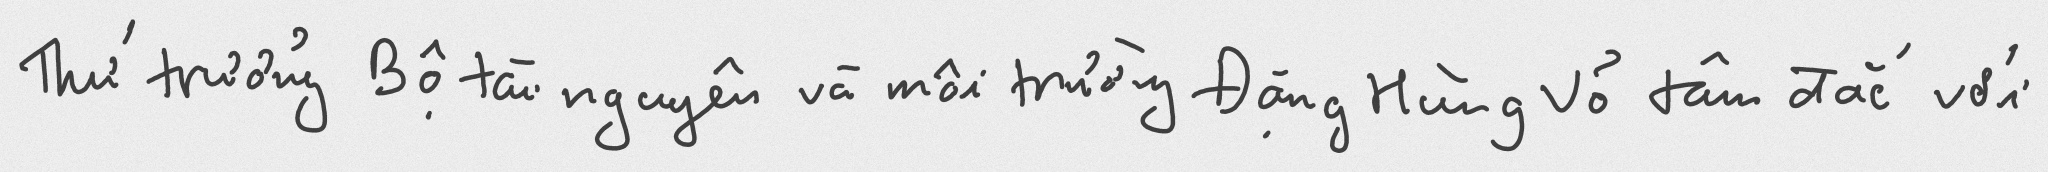

In [24]:
image_test = Image.open(image_file)
image_test

In [25]:
model.save_pretrained("lora_model") 
tokenizer.save_pretrained("lora_model")

You are using a model of type deepseek_vl_v2 to instantiate a model of type DeepseekOCR. This is not supported for all configurations of models and can yield errors.


('lora_model/tokenizer_config.json',
 'lora_model/special_tokens_map.json',
 'lora_model/tokenizer.json')

# 6. Test and evaluate fine-tuned model

In [26]:

# all_preds = []
# all_gts   = []

stdout_backup = sys.stdout
sys.stdout = open("final_output_log.txt", "w")
PROMPT = "<image>\nFree OCR. "
# tmp = 0
for c in tqdm(test_dataset, desc="Evaluating"):
    # Make sure path is absolute
    img_path, gt_text = c["image"], c["text"]

    # image = Image.open(img_path).convert("RGB")
    try:
        # # This is the EXACT same inference call you saw
        result = model.infer(
            tokenizer=tokenizer,
            prompt=PROMPT,
            image_file=img_path,
            output_path="./eval_outputs",
            image_size=640,        
            base_size=1024,
            crop_mode=True,        # ← very important for paragraph/handwriting!
            save_results=False,    # we don't need saved images
            test_compress=False
        )
        # tmp += 1
        

        print(f"y_true: {gt_text}")


        
    except Exception as e:
        print(f"Error on {img_path}: {e}")
        pred_text = ""
    # if tmp >= 10:
    #     break
    # all_preds.append(pred_text)
    # all_gts.append(gt_text)
sys.stdout.close()
sys.stdout = stdout_backup

Evaluating: 100%|██████████| 3113/3113 [3:00:46<00:00,  3.48s/it]


In [27]:
sys.stdout = sys.__stdout__

In [28]:
if False:
    from unsloth import FastVisionModel
    model, tokenizer = FastVisionModel.from_pretrained(
        model_name = "/kaggle/working/lora_model", # YOUR MODEL YOU USED FOR TRAINING
        load_in_4bit = False, # Use 4bit to reduce memory use. False for 16bit LoRA.
        auto_model = AutoModel,
        trust_remote_code=True,
        unsloth_force_compile=True,
        use_gradient_checkpointing = "unsloth", # True or "unsloth" for long context
    )
    FastVisionModel.for_inference(model) # Enable for inference!

prompt = "<image>\nFree OCR. "
image_file = '/kaggle/input/uit-hwdb-dataset/UIT_HWDB_paragraph/UIT_HWDB_paragraph/test_data/250/1.jpg'
output_path = '/kaggle/working/outputs'

# Tiny: base_size = 512, image_size = 512, crop_mode = False
# Small: base_size = 640, image_size = 640, crop_mode = False
# Base: base_size = 1024, image_size = 1024, crop_mode = False
# Large: base_size = 1280, image_size = 1280, crop_mode = False

# Gundam: base_size = 1024, image_size = 640, crop_mode = True

res = model.infer(tokenizer, prompt=prompt, image_file=image_file,
    output_path = output_path,
    image_size=640,
    base_size=1024,
    crop_mode=True,
    save_results = True,
    test_compress = False)

image: 0it [00:00, ?it/s]
other: 0it [00:00, ?it/s]


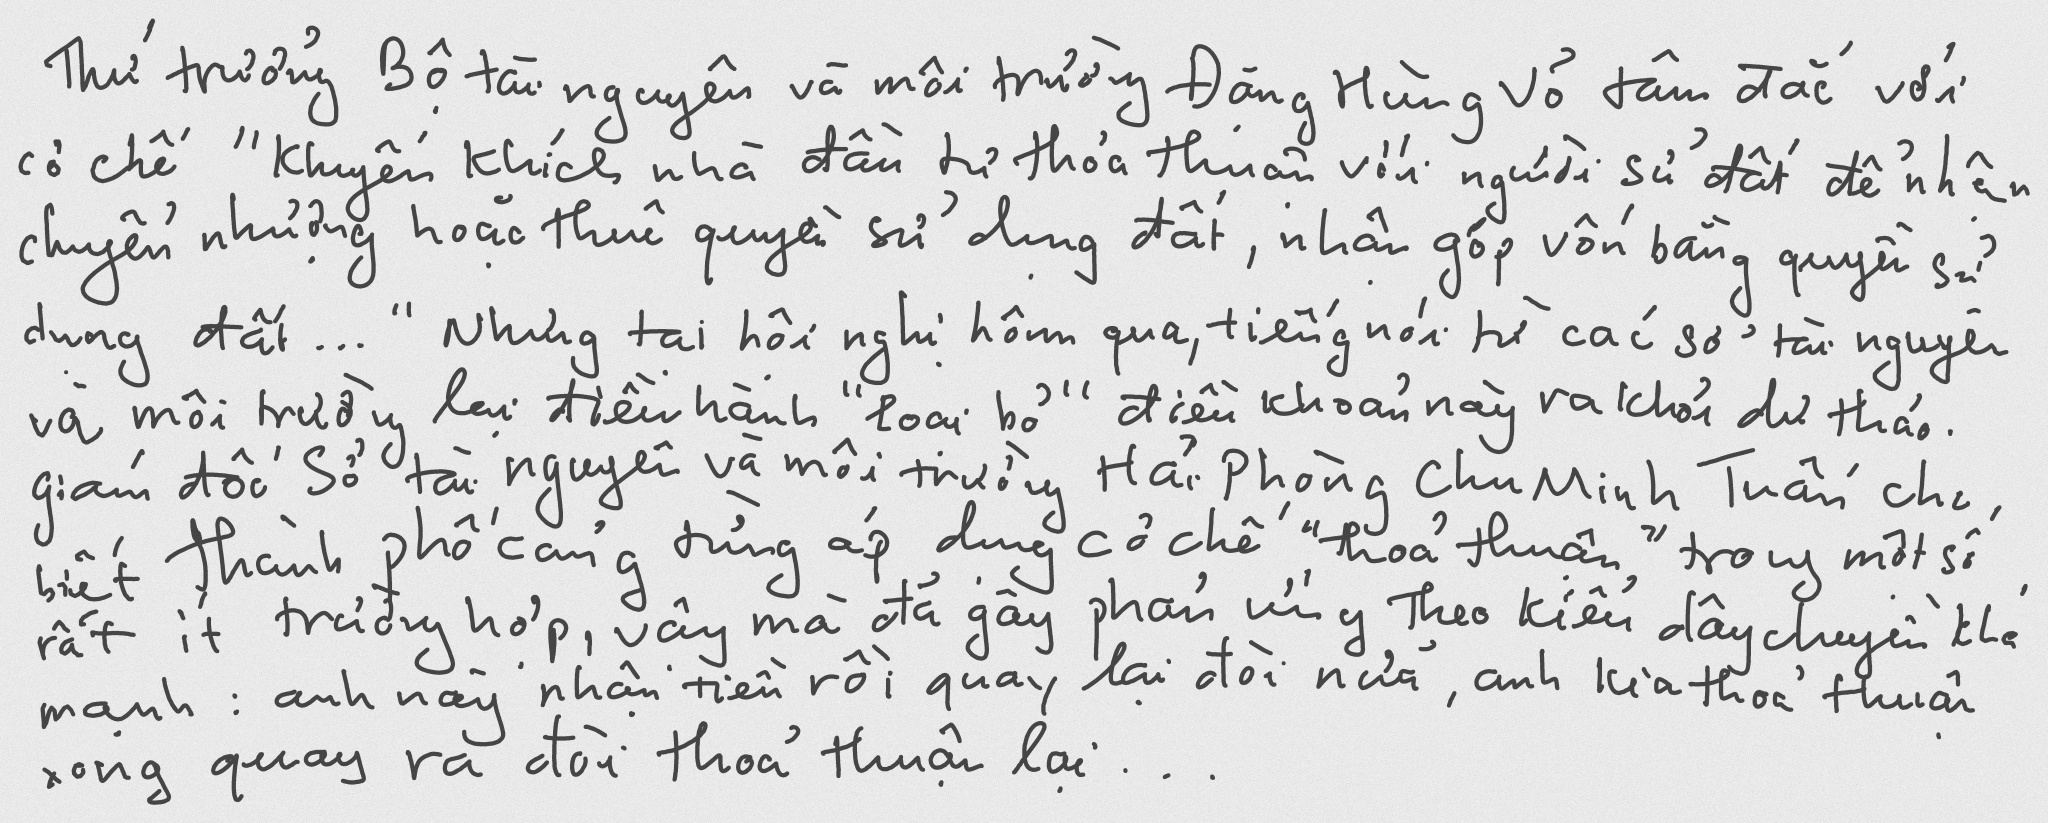

In [29]:
image_test = Image.open(image_file).convert("RGB")
image_test

## Note for further evaluation

Because of the length of this notebook, I will evaluate the outputs of both based and finetuned model in other notebook.

Thanks for reading.